## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
# !mkdir /data
# !wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
# !unzip -n /data/train-test-data.zip -d /data

<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [2]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [3]:
## TODO: Define the Net in models.py
import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12800, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=136, bias=True)
  (dropout): Dropout(p=0.4)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(256),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [5]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [6]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [7]:

# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)

In [8]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [9]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.cpu().view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [10]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [11]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

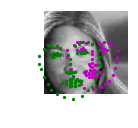

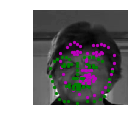

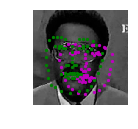

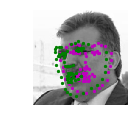

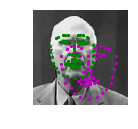

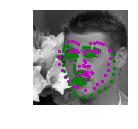

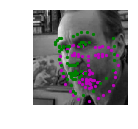

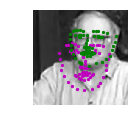

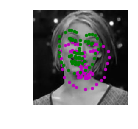

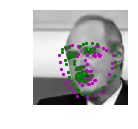

In [28]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper 
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+50
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+40
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [13]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.MSELoss()

optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum=0.9)

## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [14]:
def train_net(n_epochs):

    # prepare the net for training
    print("Loading network")
    net.train()

    print("Starting training ...")
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)
            
            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0
                
        # print training statistics 
        print('Epoch: {}, Avg. Loss: {}'.format(epoch + 1, running_loss/1000))
    
    print('Finished Training')

In [15]:
import workspace_utils
from workspace_utils import active_session

In [16]:
# train your network
n_epochs = 25 # start small, and increase when you've decided on your model structure and hyperparams

with active_session():
    train_net(n_epochs)

Loading network
Starting training ...


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.025470285654067993
Epoch: 1, Batch: 20, Avg. Loss: 0.021247493922710418
Epoch: 1, Batch: 30, Avg. Loss: 0.02600898027420044
Epoch: 1, Batch: 40, Avg. Loss: 0.023520552158355714
Epoch: 1, Batch: 50, Avg. Loss: 0.013936205327510835
Epoch: 1, Batch: 60, Avg. Loss: 0.004490306958556175
Epoch: 1, Batch: 70, Avg. Loss: 0.002740499019622803
Epoch: 1, Batch: 80, Avg. Loss: 0.0024855079501867293
Epoch: 1, Batch: 90, Avg. Loss: 0.002498602956533432
Epoch: 1, Batch: 100, Avg. Loss: 0.003048994205892086
Epoch: 1, Batch: 110, Avg. Loss: 0.002365627884864807
Epoch: 1, Batch: 120, Avg. Loss: 0.002227330759167671
Epoch: 1, Batch: 130, Avg. Loss: 0.0025845775827765464
Epoch: 1, Batch: 140, Avg. Loss: 0.0019939887821674345
Epoch: 1, Batch: 150, Avg. Loss: 0.0023550829589366914
Epoch: 1, Batch: 160, Avg. Loss: 0.0022035954147577286
Epoch: 1, Batch: 170, Avg. Loss: 0.0022204166799783707
Epoch: 1, Batch: 180, Avg. Loss: 0.0022160409912467005
Epoch: 1, Batch: 190, Avg. Loss

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.0025023245215415953
Epoch: 2, Batch: 20, Avg. Loss: 0.002303334467113018
Epoch: 2, Batch: 30, Avg. Loss: 0.0026272412538528443
Epoch: 2, Batch: 40, Avg. Loss: 0.0024866710901260375
Epoch: 2, Batch: 50, Avg. Loss: 0.003638462156057358
Epoch: 2, Batch: 60, Avg. Loss: 0.0023852087557315826
Epoch: 2, Batch: 70, Avg. Loss: 0.0026854839324951174
Epoch: 2, Batch: 80, Avg. Loss: 0.0018400080427527427
Epoch: 2, Batch: 90, Avg. Loss: 0.0025346797853708267
Epoch: 2, Batch: 100, Avg. Loss: 0.0024379236325621605
Epoch: 2, Batch: 110, Avg. Loss: 0.0025532638430595398
Epoch: 2, Batch: 120, Avg. Loss: 0.002565474554896355
Epoch: 2, Batch: 130, Avg. Loss: 0.001980338029563427
Epoch: 2, Batch: 140, Avg. Loss: 0.00207400381565094
Epoch: 2, Batch: 150, Avg. Loss: 0.0022239370197057722
Epoch: 2, Batch: 160, Avg. Loss: 0.00287232731282711
Epoch: 2, Batch: 170, Avg. Loss: 0.0023946301937103273
Epoch: 2, Batch: 180, Avg. Loss: 0.0022432260811328887
Epoch: 2, Batch: 190, Avg. 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.002284361496567726
Epoch: 3, Batch: 20, Avg. Loss: 0.002009946286678314
Epoch: 3, Batch: 30, Avg. Loss: 0.001987602055072784
Epoch: 3, Batch: 40, Avg. Loss: 0.002258212514221668
Epoch: 3, Batch: 50, Avg. Loss: 0.0022407258450984954
Epoch: 3, Batch: 60, Avg. Loss: 0.0022427295222878455
Epoch: 3, Batch: 70, Avg. Loss: 0.002493154302239418
Epoch: 3, Batch: 80, Avg. Loss: 0.0021249110102653504
Epoch: 3, Batch: 90, Avg. Loss: 0.00236585596203804
Epoch: 3, Batch: 100, Avg. Loss: 0.00270279710739851
Epoch: 3, Batch: 110, Avg. Loss: 0.002302347809076309
Epoch: 3, Batch: 120, Avg. Loss: 0.0023162151277065276
Epoch: 3, Batch: 130, Avg. Loss: 0.0028241869509220124
Epoch: 3, Batch: 140, Avg. Loss: 0.002439392663538456
Epoch: 3, Batch: 150, Avg. Loss: 0.0024978968501091
Epoch: 3, Batch: 160, Avg. Loss: 0.0027265173494815825
Epoch: 3, Batch: 170, Avg. Loss: 0.0025540297478437424
Epoch: 3, Batch: 180, Avg. Loss: 0.0022789007723331453
Epoch: 3, Batch: 190, Avg. Loss: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.0029274519979953766
Epoch: 4, Batch: 20, Avg. Loss: 0.0023453436121344566
Epoch: 4, Batch: 30, Avg. Loss: 0.002149823307991028
Epoch: 4, Batch: 40, Avg. Loss: 0.002088961936533451
Epoch: 4, Batch: 50, Avg. Loss: 0.0020295119136571884
Epoch: 4, Batch: 60, Avg. Loss: 0.003229337975382805
Epoch: 4, Batch: 70, Avg. Loss: 0.0023901783972978593
Epoch: 4, Batch: 80, Avg. Loss: 0.0019831420630216597
Epoch: 4, Batch: 90, Avg. Loss: 0.0025605214685201646
Epoch: 4, Batch: 100, Avg. Loss: 0.0024568760693073274
Epoch: 4, Batch: 110, Avg. Loss: 0.002548254385590553
Epoch: 4, Batch: 120, Avg. Loss: 0.0021950287967920303
Epoch: 4, Batch: 130, Avg. Loss: 0.002124321177601814
Epoch: 4, Batch: 140, Avg. Loss: 0.002932110384106636
Epoch: 4, Batch: 150, Avg. Loss: 0.0025253743827342986
Epoch: 4, Batch: 160, Avg. Loss: 0.002505058005452156
Epoch: 4, Batch: 170, Avg. Loss: 0.0023988276943564413
Epoch: 4, Batch: 180, Avg. Loss: 0.0031065962314605713
Epoch: 4, Batch: 190, Avg.

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.0023728544116020205
Epoch: 5, Batch: 20, Avg. Loss: 0.0025006145387887957
Epoch: 5, Batch: 30, Avg. Loss: 0.0028144162595272063
Epoch: 5, Batch: 40, Avg. Loss: 0.0054063240587711335
Epoch: 5, Batch: 50, Avg. Loss: 0.002204267382621765
Epoch: 5, Batch: 60, Avg. Loss: 0.0026369201689958573
Epoch: 5, Batch: 70, Avg. Loss: 0.0022643466740846635
Epoch: 5, Batch: 80, Avg. Loss: 0.002324791893362999
Epoch: 5, Batch: 90, Avg. Loss: 0.0026029633283615114
Epoch: 5, Batch: 100, Avg. Loss: 0.0022358910664916037
Epoch: 5, Batch: 110, Avg. Loss: 0.0020543995499610903
Epoch: 5, Batch: 120, Avg. Loss: 0.0020705345645546914
Epoch: 5, Batch: 130, Avg. Loss: 0.0022367864698171615
Epoch: 5, Batch: 140, Avg. Loss: 0.002775102987885475
Epoch: 5, Batch: 150, Avg. Loss: 0.002350451685488224
Epoch: 5, Batch: 160, Avg. Loss: 0.002528700888156891
Epoch: 5, Batch: 170, Avg. Loss: 0.002601060666143894
Epoch: 5, Batch: 180, Avg. Loss: 0.002423713520169258
Epoch: 5, Batch: 190, Avg.

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 10, Avg. Loss: 0.0022966049760580064
Epoch: 6, Batch: 20, Avg. Loss: 0.002110417127609253
Epoch: 6, Batch: 30, Avg. Loss: 0.0025645188093185423
Epoch: 6, Batch: 40, Avg. Loss: 0.002322538420557976
Epoch: 6, Batch: 50, Avg. Loss: 0.00180556882917881
Epoch: 6, Batch: 60, Avg. Loss: 0.002102611005306244
Epoch: 6, Batch: 70, Avg. Loss: 0.0024533621966838838
Epoch: 6, Batch: 80, Avg. Loss: 0.0023373186737298966
Epoch: 6, Batch: 90, Avg. Loss: 0.0023293451145291327
Epoch: 6, Batch: 100, Avg. Loss: 0.0022817435562610625
Epoch: 6, Batch: 110, Avg. Loss: 0.002682543486356735
Epoch: 6, Batch: 120, Avg. Loss: 0.00221981917321682
Epoch: 6, Batch: 130, Avg. Loss: 0.0022907420247793198
Epoch: 6, Batch: 140, Avg. Loss: 0.0022807555496692656
Epoch: 6, Batch: 150, Avg. Loss: 0.0030849562808871267
Epoch: 6, Batch: 160, Avg. Loss: 0.0024664414674043654
Epoch: 6, Batch: 170, Avg. Loss: 0.0027027726620435714
Epoch: 6, Batch: 180, Avg. Loss: 0.002065311074256897
Epoch: 6, Batch: 190, Avg. L

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 10, Avg. Loss: 0.0028527161329984663
Epoch: 7, Batch: 20, Avg. Loss: 0.0024294465631246568
Epoch: 7, Batch: 30, Avg. Loss: 0.0034826968908309936
Epoch: 7, Batch: 40, Avg. Loss: 0.002031339317560196
Epoch: 7, Batch: 50, Avg. Loss: 0.002427097827196121
Epoch: 7, Batch: 60, Avg. Loss: 0.0026383405923843385
Epoch: 7, Batch: 70, Avg. Loss: 0.0022326853424310686
Epoch: 7, Batch: 80, Avg. Loss: 0.002322658658027649
Epoch: 7, Batch: 90, Avg. Loss: 0.002535414032638073
Epoch: 7, Batch: 100, Avg. Loss: 0.0018920385688543319
Epoch: 7, Batch: 110, Avg. Loss: 0.003926558330655098
Epoch: 7, Batch: 120, Avg. Loss: 0.0037577585279941557
Epoch: 7, Batch: 130, Avg. Loss: 0.0021381961703300476
Epoch: 7, Batch: 140, Avg. Loss: 0.002281174637377262
Epoch: 7, Batch: 150, Avg. Loss: 0.0023655825555324553
Epoch: 7, Batch: 160, Avg. Loss: 0.002291177451610565
Epoch: 7, Batch: 170, Avg. Loss: 0.003039040043950081
Epoch: 7, Batch: 180, Avg. Loss: 0.002512830913066864
Epoch: 7, Batch: 190, Avg. L

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 10, Avg. Loss: 0.002319242365658283
Epoch: 8, Batch: 20, Avg. Loss: 0.002088761419057846
Epoch: 8, Batch: 30, Avg. Loss: 0.0032098734378814696
Epoch: 8, Batch: 40, Avg. Loss: 0.0025035467594861985
Epoch: 8, Batch: 50, Avg. Loss: 0.0020827493965625762
Epoch: 8, Batch: 60, Avg. Loss: 0.002240625701844692
Epoch: 8, Batch: 70, Avg. Loss: 0.0018599756583571434
Epoch: 8, Batch: 80, Avg. Loss: 0.0021332677602767945
Epoch: 8, Batch: 90, Avg. Loss: 0.0027787976711988447
Epoch: 8, Batch: 100, Avg. Loss: 0.002221223548054695
Epoch: 8, Batch: 110, Avg. Loss: 0.002779988706111908
Epoch: 8, Batch: 120, Avg. Loss: 0.002326096147298813
Epoch: 8, Batch: 130, Avg. Loss: 0.002757097601890564
Epoch: 8, Batch: 140, Avg. Loss: 0.0022807720750570295
Epoch: 8, Batch: 150, Avg. Loss: 0.0023887951523065567
Epoch: 8, Batch: 160, Avg. Loss: 0.0028082994222640993
Epoch: 8, Batch: 170, Avg. Loss: 0.002490150898694992
Epoch: 8, Batch: 180, Avg. Loss: 0.0026592185348272325
Epoch: 8, Batch: 190, Avg. 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 10, Avg. Loss: 0.002400214061141014
Epoch: 9, Batch: 20, Avg. Loss: 0.0021050596684217453
Epoch: 9, Batch: 30, Avg. Loss: 0.0028883776888251303
Epoch: 9, Batch: 40, Avg. Loss: 0.002220649629831314
Epoch: 9, Batch: 50, Avg. Loss: 0.002209472343325615
Epoch: 9, Batch: 60, Avg. Loss: 0.0023965423107147215
Epoch: 9, Batch: 70, Avg. Loss: 0.0022775044813752175
Epoch: 9, Batch: 80, Avg. Loss: 0.0019699907526373865
Epoch: 9, Batch: 90, Avg. Loss: 0.002607416868209839
Epoch: 9, Batch: 100, Avg. Loss: 0.002093881696462631
Epoch: 9, Batch: 110, Avg. Loss: 0.0026527735143899917
Epoch: 9, Batch: 120, Avg. Loss: 0.003042964830994606
Epoch: 9, Batch: 130, Avg. Loss: 0.002587569907307625
Epoch: 9, Batch: 140, Avg. Loss: 0.0023477314114570616
Epoch: 9, Batch: 150, Avg. Loss: 0.002269820801913738
Epoch: 9, Batch: 160, Avg. Loss: 0.002342528313398361
Epoch: 9, Batch: 170, Avg. Loss: 0.002217300683259964
Epoch: 9, Batch: 180, Avg. Loss: 0.0026559599936008455
Epoch: 9, Batch: 190, Avg. Lo

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 10, Avg. Loss: 0.0031918192952871322
Epoch: 10, Batch: 20, Avg. Loss: 0.002230062171816826
Epoch: 10, Batch: 30, Avg. Loss: 0.002386198773980141
Epoch: 10, Batch: 40, Avg. Loss: 0.0022888487875461576
Epoch: 10, Batch: 50, Avg. Loss: 0.0018558669164776803
Epoch: 10, Batch: 60, Avg. Loss: 0.004073995366692543
Epoch: 10, Batch: 70, Avg. Loss: 0.0021461689323186875
Epoch: 10, Batch: 80, Avg. Loss: 0.0018362649753689766
Epoch: 10, Batch: 90, Avg. Loss: 0.002161379784345627
Epoch: 10, Batch: 100, Avg. Loss: 0.0022534319460392
Epoch: 10, Batch: 110, Avg. Loss: 0.0020153841823339464
Epoch: 10, Batch: 120, Avg. Loss: 0.0022990438044071197
Epoch: 10, Batch: 130, Avg. Loss: 0.0023440415263175965
Epoch: 10, Batch: 140, Avg. Loss: 0.002525779724121094
Epoch: 10, Batch: 150, Avg. Loss: 0.0026033664643764494
Epoch: 10, Batch: 160, Avg. Loss: 0.0026841868907213212
Epoch: 10, Batch: 170, Avg. Loss: 0.002533036105334759
Epoch: 10, Batch: 180, Avg. Loss: 0.002149618461728096
Epoch: 10, 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 11, Batch: 10, Avg. Loss: 0.002048886626958847
Epoch: 11, Batch: 20, Avg. Loss: 0.002095210313796997
Epoch: 11, Batch: 30, Avg. Loss: 0.0025616215765476226
Epoch: 11, Batch: 40, Avg. Loss: 0.0021409588605165483
Epoch: 11, Batch: 50, Avg. Loss: 0.0022757814824581144
Epoch: 11, Batch: 60, Avg. Loss: 0.001982936702668667
Epoch: 11, Batch: 70, Avg. Loss: 0.0019772677347064016
Epoch: 11, Batch: 80, Avg. Loss: 0.0023137247264385223
Epoch: 11, Batch: 90, Avg. Loss: 0.002549550071358681
Epoch: 11, Batch: 100, Avg. Loss: 0.0018443292230367662
Epoch: 11, Batch: 110, Avg. Loss: 0.002264197826385498
Epoch: 11, Batch: 120, Avg. Loss: 0.002808341734111309
Epoch: 11, Batch: 130, Avg. Loss: 0.002230033457279205
Epoch: 11, Batch: 140, Avg. Loss: 0.0018558511286973953
Epoch: 11, Batch: 150, Avg. Loss: 0.0027674148380756377
Epoch: 11, Batch: 160, Avg. Loss: 0.00219184385240078
Epoch: 11, Batch: 170, Avg. Loss: 0.002559657230973244
Epoch: 11, Batch: 180, Avg. Loss: 0.003093311086297035
Epoch: 11, B

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 12, Batch: 10, Avg. Loss: 0.002571764722466469
Epoch: 12, Batch: 20, Avg. Loss: 0.003002800107002258
Epoch: 12, Batch: 30, Avg. Loss: 0.0022335434705018998
Epoch: 12, Batch: 40, Avg. Loss: 0.0024102111458778382
Epoch: 12, Batch: 50, Avg. Loss: 0.002031336396932602
Epoch: 12, Batch: 60, Avg. Loss: 0.002217164397239685
Epoch: 12, Batch: 70, Avg. Loss: 0.0020278037935495376
Epoch: 12, Batch: 80, Avg. Loss: 0.002076706863939762
Epoch: 12, Batch: 90, Avg. Loss: 0.0019150633215904236
Epoch: 12, Batch: 100, Avg. Loss: 0.0022993276864290237
Epoch: 12, Batch: 110, Avg. Loss: 0.002846379801630974
Epoch: 12, Batch: 120, Avg. Loss: 0.0023389303386211397
Epoch: 12, Batch: 130, Avg. Loss: 0.002797182433307171
Epoch: 12, Batch: 140, Avg. Loss: 0.0023750945925712585
Epoch: 12, Batch: 150, Avg. Loss: 0.0024997642934322358
Epoch: 12, Batch: 160, Avg. Loss: 0.002841462850570679
Epoch: 12, Batch: 170, Avg. Loss: 0.0022026120722293853
Epoch: 12, Batch: 180, Avg. Loss: 0.002795653872191906
Epoch: 12,

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 13, Batch: 10, Avg. Loss: 0.0023260049968957903
Epoch: 13, Batch: 20, Avg. Loss: 0.002123302571475506
Epoch: 13, Batch: 30, Avg. Loss: 0.002422406107187271
Epoch: 13, Batch: 40, Avg. Loss: 0.0022530928254127502
Epoch: 13, Batch: 50, Avg. Loss: 0.00346144500374794
Epoch: 13, Batch: 60, Avg. Loss: 0.0021927682012319563
Epoch: 13, Batch: 70, Avg. Loss: 0.0031158829033374785
Epoch: 13, Batch: 80, Avg. Loss: 0.0020764034539461134
Epoch: 13, Batch: 90, Avg. Loss: 0.0027166029512882234
Epoch: 13, Batch: 100, Avg. Loss: 0.0022468550205230714
Epoch: 13, Batch: 110, Avg. Loss: 0.002469973638653755
Epoch: 13, Batch: 120, Avg. Loss: 0.003046519502997398
Epoch: 13, Batch: 130, Avg. Loss: 0.0025941263139247894
Epoch: 13, Batch: 140, Avg. Loss: 0.002156248852610588
Epoch: 13, Batch: 150, Avg. Loss: 0.002655731499195099
Epoch: 13, Batch: 160, Avg. Loss: 0.0021329804882407187
Epoch: 13, Batch: 170, Avg. Loss: 0.0020423384830355646
Epoch: 13, Batch: 180, Avg. Loss: 0.0023814253956079483
Epoch: 13

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 14, Batch: 10, Avg. Loss: 0.002839775025844574
Epoch: 14, Batch: 20, Avg. Loss: 0.0029093950390815734
Epoch: 14, Batch: 30, Avg. Loss: 0.002067711219191551
Epoch: 14, Batch: 40, Avg. Loss: 0.0026582822054624557
Epoch: 14, Batch: 50, Avg. Loss: 0.0019357898160815238
Epoch: 14, Batch: 60, Avg. Loss: 0.0027737550288438797
Epoch: 14, Batch: 70, Avg. Loss: 0.002111333452165127
Epoch: 14, Batch: 80, Avg. Loss: 0.002605990648269653
Epoch: 14, Batch: 90, Avg. Loss: 0.0026908874064683914
Epoch: 14, Batch: 100, Avg. Loss: 0.0021753331273794176
Epoch: 14, Batch: 110, Avg. Loss: 0.0020032983124256133
Epoch: 14, Batch: 120, Avg. Loss: 0.002367747448384762
Epoch: 14, Batch: 130, Avg. Loss: 0.0018918814063072205
Epoch: 14, Batch: 140, Avg. Loss: 0.002175213284790516
Epoch: 14, Batch: 150, Avg. Loss: 0.0018516061007976532
Epoch: 14, Batch: 160, Avg. Loss: 0.002279721550643444
Epoch: 14, Batch: 170, Avg. Loss: 0.002149412453174591
Epoch: 14, Batch: 180, Avg. Loss: 0.004720892637968064
Epoch: 14,

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 15, Batch: 10, Avg. Loss: 0.0022652674093842505
Epoch: 15, Batch: 20, Avg. Loss: 0.002149739235639572
Epoch: 15, Batch: 30, Avg. Loss: 0.0019521578103303908
Epoch: 15, Batch: 40, Avg. Loss: 0.0025649266839027404
Epoch: 15, Batch: 50, Avg. Loss: 0.0022263967618346213
Epoch: 15, Batch: 60, Avg. Loss: 0.002736340157687664
Epoch: 15, Batch: 70, Avg. Loss: 0.0023192262426018715
Epoch: 15, Batch: 80, Avg. Loss: 0.0020633697509765624
Epoch: 15, Batch: 90, Avg. Loss: 0.0026590904891490934
Epoch: 15, Batch: 100, Avg. Loss: 0.00249052245169878
Epoch: 15, Batch: 110, Avg. Loss: 0.002234492853283882
Epoch: 15, Batch: 120, Avg. Loss: 0.002570941612124443
Epoch: 15, Batch: 130, Avg. Loss: 0.002172699637711048
Epoch: 15, Batch: 140, Avg. Loss: 0.0018760954290628433
Epoch: 15, Batch: 150, Avg. Loss: 0.0023289483040571215
Epoch: 15, Batch: 160, Avg. Loss: 0.003253651827573776
Epoch: 15, Batch: 170, Avg. Loss: 0.002361675925552845
Epoch: 15, Batch: 180, Avg. Loss: 0.0020896872580051422
Epoch: 15,

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 16, Batch: 10, Avg. Loss: 0.002213282763957977
Epoch: 16, Batch: 20, Avg. Loss: 0.0022179457247257233
Epoch: 16, Batch: 30, Avg. Loss: 0.0025727277398109438
Epoch: 16, Batch: 40, Avg. Loss: 0.002105182521045208
Epoch: 16, Batch: 50, Avg. Loss: 0.0019228953570127488
Epoch: 16, Batch: 60, Avg. Loss: 0.0022032619789242743
Epoch: 16, Batch: 70, Avg. Loss: 0.0025206230282783506
Epoch: 16, Batch: 80, Avg. Loss: 0.0017791224271059035
Epoch: 16, Batch: 90, Avg. Loss: 0.0025102828592061996
Epoch: 16, Batch: 100, Avg. Loss: 0.0024028288573026656
Epoch: 16, Batch: 110, Avg. Loss: 0.0027974399626255037
Epoch: 16, Batch: 120, Avg. Loss: 0.0025361302345991133
Epoch: 16, Batch: 130, Avg. Loss: 0.0027028807997703554
Epoch: 16, Batch: 140, Avg. Loss: 0.001913750320672989
Epoch: 16, Batch: 150, Avg. Loss: 0.0024079313352704046
Epoch: 16, Batch: 160, Avg. Loss: 0.0024244931936264038
Epoch: 16, Batch: 170, Avg. Loss: 0.002302794620394707
Epoch: 16, Batch: 180, Avg. Loss: 0.0024531496912240983
Epoch

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 17, Batch: 10, Avg. Loss: 0.002875006407499313
Epoch: 17, Batch: 20, Avg. Loss: 0.0035345381796360016
Epoch: 17, Batch: 30, Avg. Loss: 0.0023405257761478426
Epoch: 17, Batch: 40, Avg. Loss: 0.0017375224009156228
Epoch: 17, Batch: 50, Avg. Loss: 0.002358016401529312
Epoch: 17, Batch: 60, Avg. Loss: 0.0025629033297300337
Epoch: 17, Batch: 70, Avg. Loss: 0.002239374294877052
Epoch: 17, Batch: 80, Avg. Loss: 0.0024297700747847556
Epoch: 17, Batch: 90, Avg. Loss: 0.0018590784668922424
Epoch: 17, Batch: 100, Avg. Loss: 0.002563237398862839
Epoch: 17, Batch: 110, Avg. Loss: 0.00237096755951643
Epoch: 17, Batch: 120, Avg. Loss: 0.002241730824112892
Epoch: 17, Batch: 130, Avg. Loss: 0.002566034063696861
Epoch: 17, Batch: 140, Avg. Loss: 0.002153046175837517
Epoch: 17, Batch: 150, Avg. Loss: 0.002703483462333679
Epoch: 17, Batch: 160, Avg. Loss: 0.00230047570168972
Epoch: 17, Batch: 170, Avg. Loss: 0.0022124933004379274
Epoch: 17, Batch: 180, Avg. Loss: 0.0024878310710191726
Epoch: 17, Ba

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 18, Batch: 10, Avg. Loss: 0.0025760831087827682
Epoch: 18, Batch: 20, Avg. Loss: 0.002502537593245506
Epoch: 18, Batch: 30, Avg. Loss: 0.002537341743707657
Epoch: 18, Batch: 40, Avg. Loss: 0.002290018990635872
Epoch: 18, Batch: 50, Avg. Loss: 0.0017478702664375306
Epoch: 18, Batch: 60, Avg. Loss: 0.002140137165784836
Epoch: 18, Batch: 70, Avg. Loss: 0.0024321908801794054
Epoch: 18, Batch: 80, Avg. Loss: 0.00204488555341959
Epoch: 18, Batch: 90, Avg. Loss: 0.0024411003142595293
Epoch: 18, Batch: 100, Avg. Loss: 0.0023757106363773346
Epoch: 18, Batch: 110, Avg. Loss: 0.0027036372050642968
Epoch: 18, Batch: 120, Avg. Loss: 0.0022504497319459915
Epoch: 18, Batch: 130, Avg. Loss: 0.00226110565662384
Epoch: 18, Batch: 140, Avg. Loss: 0.0020977306067943573
Epoch: 18, Batch: 150, Avg. Loss: 0.004264255002140999
Epoch: 18, Batch: 160, Avg. Loss: 0.0026818059831857683
Epoch: 18, Batch: 170, Avg. Loss: 0.002246572032570839
Epoch: 18, Batch: 180, Avg. Loss: 0.003421216577291489
Epoch: 18, B

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 19, Batch: 10, Avg. Loss: 0.0023664070963859557
Epoch: 19, Batch: 20, Avg. Loss: 0.0021565239876508713
Epoch: 19, Batch: 30, Avg. Loss: 0.0020965245664119722
Epoch: 19, Batch: 40, Avg. Loss: 0.0023701336085796354
Epoch: 19, Batch: 50, Avg. Loss: 0.002282145231962204
Epoch: 19, Batch: 60, Avg. Loss: 0.0025186872184276583
Epoch: 19, Batch: 70, Avg. Loss: 0.0020458705574274063
Epoch: 19, Batch: 80, Avg. Loss: 0.002243048325181007
Epoch: 19, Batch: 90, Avg. Loss: 0.0034670628383755685
Epoch: 19, Batch: 100, Avg. Loss: 0.0023517373353242874
Epoch: 19, Batch: 110, Avg. Loss: 0.0025233847722411157
Epoch: 19, Batch: 120, Avg. Loss: 0.002829642131924629
Epoch: 19, Batch: 130, Avg. Loss: 0.002068798840045929
Epoch: 19, Batch: 140, Avg. Loss: 0.002238698333501816
Epoch: 19, Batch: 150, Avg. Loss: 0.0024029717594385145
Epoch: 19, Batch: 160, Avg. Loss: 0.002350242964923382
Epoch: 19, Batch: 170, Avg. Loss: 0.0030735311508178712
Epoch: 19, Batch: 180, Avg. Loss: 0.002071970894932747
Epoch: 1

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 20, Batch: 10, Avg. Loss: 0.0026596159636974336
Epoch: 20, Batch: 20, Avg. Loss: 0.0021104690879583357
Epoch: 20, Batch: 30, Avg. Loss: 0.00214931258559227
Epoch: 20, Batch: 40, Avg. Loss: 0.0019973326325416563
Epoch: 20, Batch: 50, Avg. Loss: 0.0024867235124111176
Epoch: 20, Batch: 60, Avg. Loss: 0.0021502467393875123
Epoch: 20, Batch: 70, Avg. Loss: 0.002051857016980648
Epoch: 20, Batch: 80, Avg. Loss: 0.002393854171037674
Epoch: 20, Batch: 90, Avg. Loss: 0.0024048492312431337
Epoch: 20, Batch: 100, Avg. Loss: 0.0024158852100372315
Epoch: 20, Batch: 110, Avg. Loss: 0.002185710817575455
Epoch: 20, Batch: 120, Avg. Loss: 0.002437707096338272
Epoch: 20, Batch: 130, Avg. Loss: 0.002030677154660225
Epoch: 20, Batch: 140, Avg. Loss: 0.0021458606272935867
Epoch: 20, Batch: 150, Avg. Loss: 0.002822956755757332
Epoch: 20, Batch: 160, Avg. Loss: 0.0029576180279254913
Epoch: 20, Batch: 170, Avg. Loss: 0.0022213997766375544
Epoch: 20, Batch: 180, Avg. Loss: 0.002324154570698738
Epoch: 20,

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 21, Batch: 10, Avg. Loss: 0.002562050223350525
Epoch: 21, Batch: 20, Avg. Loss: 0.002877764292061329
Epoch: 21, Batch: 30, Avg. Loss: 0.002540314570069313
Epoch: 21, Batch: 40, Avg. Loss: 0.0024193537160754203
Epoch: 21, Batch: 50, Avg. Loss: 0.0017477860525250434
Epoch: 21, Batch: 60, Avg. Loss: 0.002423941031098366
Epoch: 21, Batch: 70, Avg. Loss: 0.00249381160736084
Epoch: 21, Batch: 80, Avg. Loss: 0.0020479990765452385
Epoch: 21, Batch: 90, Avg. Loss: 0.002725389361381531
Epoch: 21, Batch: 100, Avg. Loss: 0.002428755208849907
Epoch: 21, Batch: 110, Avg. Loss: 0.0026554960682988165
Epoch: 21, Batch: 120, Avg. Loss: 0.0023143654093146326
Epoch: 21, Batch: 130, Avg. Loss: 0.0020959132611751558
Epoch: 21, Batch: 140, Avg. Loss: 0.0022895771339535714
Epoch: 21, Batch: 150, Avg. Loss: 0.002462919935584068
Epoch: 21, Batch: 160, Avg. Loss: 0.002168085142970085
Epoch: 21, Batch: 170, Avg. Loss: 0.0020964065790176393
Epoch: 21, Batch: 180, Avg. Loss: 0.002294781967997551
Epoch: 21, B

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 22, Batch: 10, Avg. Loss: 0.002648918151855469
Epoch: 22, Batch: 20, Avg. Loss: 0.002215438708662987
Epoch: 22, Batch: 30, Avg. Loss: 0.0024877581596374513
Epoch: 22, Batch: 40, Avg. Loss: 0.0025128474682569505
Epoch: 22, Batch: 50, Avg. Loss: 0.002554175078868866
Epoch: 22, Batch: 60, Avg. Loss: 0.002393331229686737
Epoch: 22, Batch: 70, Avg. Loss: 0.0033704551979899405
Epoch: 22, Batch: 80, Avg. Loss: 0.0019807181507349014
Epoch: 22, Batch: 90, Avg. Loss: 0.0028217623084783555
Epoch: 22, Batch: 100, Avg. Loss: 0.002387852355837822
Epoch: 22, Batch: 110, Avg. Loss: 0.002396935433149338
Epoch: 22, Batch: 120, Avg. Loss: 0.00224308080971241
Epoch: 22, Batch: 130, Avg. Loss: 0.002318731240928173
Epoch: 22, Batch: 140, Avg. Loss: 0.0024507655501365662
Epoch: 22, Batch: 150, Avg. Loss: 0.0018730819299817086
Epoch: 22, Batch: 160, Avg. Loss: 0.002762196943163872
Epoch: 22, Batch: 170, Avg. Loss: 0.0022991576567292214
Epoch: 22, Batch: 180, Avg. Loss: 0.002479102969169617
Epoch: 22, B

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 23, Batch: 10, Avg. Loss: 0.0022728616446256638
Epoch: 23, Batch: 20, Avg. Loss: 0.0022155606150627135
Epoch: 23, Batch: 30, Avg. Loss: 0.002645343214273453
Epoch: 23, Batch: 40, Avg. Loss: 0.001985068306326866
Epoch: 23, Batch: 50, Avg. Loss: 0.0026907749250531196
Epoch: 23, Batch: 60, Avg. Loss: 0.0017830176204442977
Epoch: 23, Batch: 70, Avg. Loss: 0.0021966749131679536
Epoch: 23, Batch: 80, Avg. Loss: 0.002172235243022442
Epoch: 23, Batch: 90, Avg. Loss: 0.0022810379862785338
Epoch: 23, Batch: 100, Avg. Loss: 0.002810984045267105
Epoch: 23, Batch: 110, Avg. Loss: 0.0023582760244607926
Epoch: 23, Batch: 120, Avg. Loss: 0.0025809230282902718
Epoch: 23, Batch: 130, Avg. Loss: 0.002248615548014641
Epoch: 23, Batch: 140, Avg. Loss: 0.002277993932366371
Epoch: 23, Batch: 150, Avg. Loss: 0.003313906155526638
Epoch: 23, Batch: 160, Avg. Loss: 0.0030552357733249665
Epoch: 23, Batch: 170, Avg. Loss: 0.0017458488568663597
Epoch: 23, Batch: 180, Avg. Loss: 0.0024487280994653702
Epoch: 2

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 24, Batch: 10, Avg. Loss: 0.0025292061865329744
Epoch: 24, Batch: 20, Avg. Loss: 0.0020707141533493996
Epoch: 24, Batch: 30, Avg. Loss: 0.0024370174407958986
Epoch: 24, Batch: 40, Avg. Loss: 0.001988870993256569
Epoch: 24, Batch: 50, Avg. Loss: 0.002022243283689022
Epoch: 24, Batch: 60, Avg. Loss: 0.0020331756472587587
Epoch: 24, Batch: 70, Avg. Loss: 0.002298483982682228
Epoch: 24, Batch: 80, Avg. Loss: 0.002152446337044239
Epoch: 24, Batch: 90, Avg. Loss: 0.002891891419887543
Epoch: 24, Batch: 100, Avg. Loss: 0.002555708073079586
Epoch: 24, Batch: 110, Avg. Loss: 0.0029966538697481157
Epoch: 24, Batch: 120, Avg. Loss: 0.0024191642850637436
Epoch: 24, Batch: 130, Avg. Loss: 0.0023533923551440237
Epoch: 24, Batch: 140, Avg. Loss: 0.0023277685940265654
Epoch: 24, Batch: 150, Avg. Loss: 0.0021679055243730544
Epoch: 24, Batch: 160, Avg. Loss: 0.0023938752710819244
Epoch: 24, Batch: 170, Avg. Loss: 0.0023066559731960297
Epoch: 24, Batch: 180, Avg. Loss: 0.0021798509359359742
Epoch: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 25, Batch: 10, Avg. Loss: 0.0032977273911237717
Epoch: 25, Batch: 20, Avg. Loss: 0.0023012751564383508
Epoch: 25, Batch: 30, Avg. Loss: 0.0022106733694672582
Epoch: 25, Batch: 40, Avg. Loss: 0.002382267192006111
Epoch: 25, Batch: 50, Avg. Loss: 0.0019524961560964584
Epoch: 25, Batch: 60, Avg. Loss: 0.0019602705761790277
Epoch: 25, Batch: 70, Avg. Loss: 0.003974167302250862
Epoch: 25, Batch: 80, Avg. Loss: 0.001738058015704155
Epoch: 25, Batch: 90, Avg. Loss: 0.0023546355813741683
Epoch: 25, Batch: 100, Avg. Loss: 0.0025167953073978425
Epoch: 25, Batch: 110, Avg. Loss: 0.0025852541625499726
Epoch: 25, Batch: 120, Avg. Loss: 0.0023477325141429903
Epoch: 25, Batch: 130, Avg. Loss: 0.002356128424406052
Epoch: 25, Batch: 140, Avg. Loss: 0.0021739860624074934
Epoch: 25, Batch: 150, Avg. Loss: 0.0023054250776767733
Epoch: 25, Batch: 160, Avg. Loss: 0.00316953407227993
Epoch: 25, Batch: 170, Avg. Loss: 0.0025278253108263014
Epoch: 25, Batch: 180, Avg. Loss: 0.00253821362555027
Epoch: 25

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [17]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


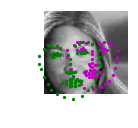

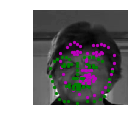

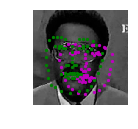

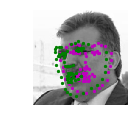

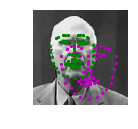

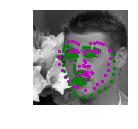

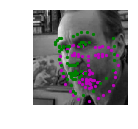

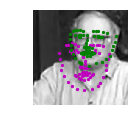

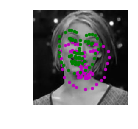

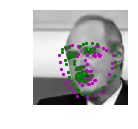

In [29]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [19]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_1.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**:

- Loss function:
<p>&nbsp;</p>
I chose the MSELoss as the loss function because it is good for regression problems like this, where you have to compare a predicted value and a target value directly.
<p>&nbsp;</p>
- Optimization:
<p>&nbsp;</p>
I chose the Stochastic Gradient Descent SGD as the optimizer because it performs well when solving problems using CNN. I also have a learning rate of 0.01. This is very good for this task. At the beginning I started with a learning rate of 0.1. But this was set too high. Plus a momentum of 0.9 to better prevent overfitting.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**:

- First I started with 3 convolutional layers. However, I was able to get better results with an additional fourth convolutional layer.
<p>&nbsp;</p>
- Between the fully connected layers (fc) I use dropout layers with p = 0.4 to reduce overfitting.
<p>&nbsp;</p>
- Here is an overview of my network architecture:

    - Convolutional Layer with 1 input dimensions and 32 output dimensions - kernel size 5
    - Relu Activation function
    - Pooling layer - kernel size 2
    - Convolutional Layer with 32 input dimensions and 64 output dimensions - kernel size 5
    - Relu Activation function
    - Pooling layer - kernel size 2
    - Convolutional Layer with 64 input dimensions and 128 output dimensions - kernel size 5
    - Relu Activation function
    - Pooling layer - kernel size 2
    - Convolutional Layer with 128 input dimensions and 128 output dimensions - kernel size 5
    - Relu Activation function
    - Pooling layer - kernel size 2
    - Flatten layer to convert the pooled feature maps to a single vector with a length of 12800
    - Dropout with a probability of 0.4
    - Fully connected Linear Layer with an input size of 25088 and an output size of 4096
    - Relu Activation function
    - Dropout with a probability of 0.4
    - Fully connected Linear Layer with an input size of 4096 and an output size of 136

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**:

- Epochs
<p>&nbsp;</p>
I experimented with the Epochs between 10 and 40. In the end, 25 epochs proved their worth in this task.
<p>&nbsp;</p>
- batch_size
<p>&nbsp;</p>
I left the batch_size of 10 as it is. If you use a SGD optimizer like in this case, a low batch_size is an advantage.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[ -1.74320862e-02  -7.94544257e-03  -1.97441205e-01  -1.69816658e-01
   -1.75243318e-01]
 [  1.10060178e-01  -2.05901027e-01   4.91741784e-02   6.10000825e-05
    1.75081998e-01]
 [ -4.99227606e-02   1.28427416e-01  -1.02248028e-01   1.24742411e-01
   -1.47176296e-01]
 [ -8.03720430e-02   8.95280465e-02  -1.85222626e-02   1.25190556e-01
   -1.68294415e-01]
 [  1.47298258e-02   1.20534256e-01   1.59016520e-01  -2.01353252e-01
    5.83070926e-02]]
(5, 5)


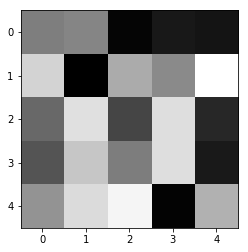

In [20]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

Text(0.5,1,'Filtered image')

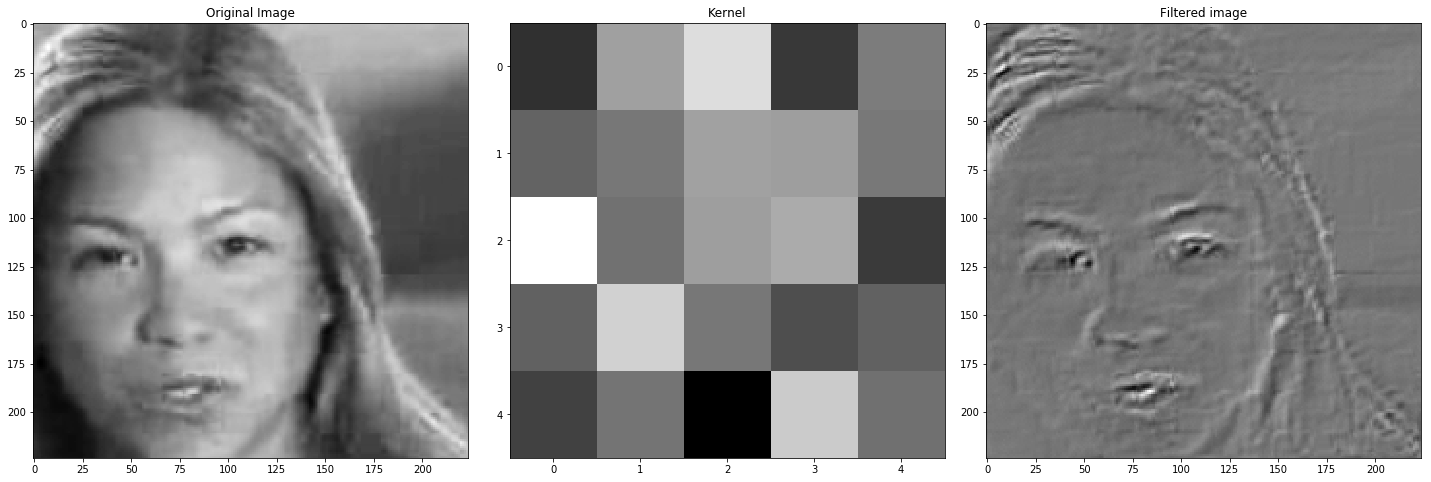

In [32]:
import cv2
# Define figsize
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(20, 20))
f.tight_layout()

# Index of filter
filter_index = 8

##TODO: load in and display any image from the transformed test dataset
img_idx = 0
image = test_images[img_idx]
image = image.numpy()   # convert to numpy array from a Tensor
image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

# Show original image
ax1.imshow(np.squeeze(image), cmap='gray')
ax1.set_title('Original Image')

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image

ax2.imshow(w[filter_index][0], cmap='gray')
ax2.set_title('Kernel')

# Display filtered image
c = cv2.filter2D(image, -1, w[filter_index][0])
ax3.imshow(c, cmap='gray')
ax3.set_title('Filtered image')

# weights1 = net.conv1.weight.data

# w = weights1.numpy()

# filter_index = 0

# print(w[filter_index][0])
# print(w[filter_index][0].shape)

# # display the filter weights
# # plt.imshow(w[filter_index][0], cmap='gray')


# idx_img = 0
# img = np.squeeze(test_images[idx_img].data.numpy())

# # plt.imshow(img, cmap="gray")

# filtered_img = cv2.filter2D(img, -1, w[filter_index][0])
# plt.imshow(filtered_img, cmap="gray")

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: (does it detect vertical lines or does it blur out noise, etc.) write your answer here

The kernel shows very well that it can recognize horizontal shapes. The upper part of the kernel is designed rather dark on average, the lower part is brighter.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!